# Example: Boston Airbnb Listings

Data: https://www.kaggle.com/datasets/katerynaosadchuk/boston-airbnb-listings

**Cilj: Algoritem za napovedovanje cene**

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# to display the total number columns present in the dataset
pd.set_option('display.max_columns', None)

## Basic cleaning

In [2]:
import ast

# load
file_name = "data/boston_listings.csv"
airbnb_boston = pd.read_csv(file_name)

# clean price and cleaning_fee columns
airbnb_boston['price_usd'] = airbnb_boston['price'].str.replace("$", "").str.replace(",", "").astype("float")
airbnb_boston['cleaning_fee_usd'] = airbnb_boston['cleaning_fee'].str.replace("$", "").str.replace(",", "").astype("float")
airbnb_boston.drop(columns=["price", "cleaning_fee"], inplace=True)

# remove unusable columns
columns_to_remove = ["id", "name", "summary", "access", "interaction", "host_id", "host_verifications", "license"]
airbnb_boston.drop(columns=columns_to_remove, inplace=True)

# Basic data check and cleaning
# Remove features - too many missing values, no data in real case (review)
columns_to_remove = ["house_rules", "host_location", "host_neighbourhood", "neighbourhood", "host_total_listings_count", \
                    "availability_30", "availability_60", "availability_90", "availability_365", "number_of_reviews", \
                    "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", \
                    "review_scores_communication", "review_scores_location", "review_scores_value", "reviews_per_month"]

airbnb_boston.drop(columns=columns_to_remove, inplace=True)
airbnb_boston.rename(columns={"neighbourhood_cleansed": "neighbourhood"}, inplace=True)

# transform types
airbnb_boston["host_since"] = pd.to_datetime(airbnb_boston["host_since"])
airbnb_boston["host_response_rate"] = airbnb_boston["host_response_rate"].str.replace("%", "").astype("float")
airbnb_boston["host_acceptance_rate"] = airbnb_boston["host_acceptance_rate"].str.replace("%", "").astype("float")
# to bool
bool_transform = {'t': True, 'f': False}
airbnb_boston["host_is_superhost"] = airbnb_boston["host_is_superhost"].replace(bool_transform)
airbnb_boston["host_identity_verified"] = airbnb_boston["host_identity_verified"].replace(bool_transform)
airbnb_boston["requires_license"] = airbnb_boston["requires_license"].replace(bool_transform)
airbnb_boston["instant_bookable"] = airbnb_boston["instant_bookable"].replace(bool_transform)
airbnb_boston["is_business_travel_ready"] = airbnb_boston["is_business_travel_ready"].replace(bool_transform)
airbnb_boston["is_location_exact"] = airbnb_boston["is_location_exact"].replace(bool_transform)

# Remove samples if is_location_exact is false
airbnb_boston = airbnb_boston[airbnb_boston['is_location_exact'] == True] 
airbnb_boston.drop(columns=["is_location_exact"], inplace=True)

# Parsing amenities_dict to 
NEW_FEATURES = ["TV", "Wifi", "Air conditioning", "Kitchen", "Heating", "Washer", "Dryer", "Smoke detector", "Essentials", \
               "Hair dryer", "Microwave", "Refrigerator", "Dishwasher", "Cooking basics", "Family/kid friendly", "Bathtub", \
               "Private entrance", "Garden or backyard", "Gym"]

def extract_apartment_features(row):
    result = {}
    row_amenities_dict = ast.literal_eval(row["amenities_dict"])
    for feature in NEW_FEATURES:
        result[feature] = False
        if feature in row_amenities_dict:
            if row_amenities_dict.get(feature) == 1:
                result[feature] = True
    return result

applied_df = airbnb_boston.apply(lambda row: extract_apartment_features(row), axis='columns', result_type='expand')
airbnb_boston = pd.concat([airbnb_boston, applied_df], axis='columns')
airbnb_boston.drop(columns=["amenities_dict"], inplace=True)
airbnb_boston.columns = [feature.lower().replace(" ", "_").replace("/", "_") for feature in airbnb_boston.columns]

In [3]:
airbnb_boston.to_pickle("data/boston_listings_clean.pkl")

## Basic prediction

Začnemo samo z numeričnimi vrednostmi in odstranimo vse vrstice, ki vsebujejo manjkajoče vrednosti:

In [5]:
print(f"[BEFORE] Number of samples: {airbnb_boston.shape}")
airbnb_boston_numeric = airbnb_boston.select_dtypes(include='number')
airbnb_boston_numeric.dropna(axis = 0, how ='any', inplace=True)
print(f"[AFTER] Number of samples: {airbnb_boston_numeric.shape}")

[BEFORE] Number of samples: (3639, 42)
[AFTER] Number of samples: (2889, 10)


In [6]:
airbnb_boston_numeric.head()

,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price_usd,cleaning_fee_usd
0,100.0,44.0,42.36413,-71.02991,2,1.0,1.0,0.0,125.0,75.0
1,100.0,100.0,42.32981,-71.09559,2,1.0,1.0,1.0,145.0,60.0
2,100.0,100.0,42.32994,-71.09351,4,1.0,1.0,1.0,169.0,80.0
3,100.0,83.0,42.35919,-71.06265,2,1.0,1.0,1.0,99.0,250.0
4,100.0,83.0,42.35840,-71.06185,2,1.0,1.0,1.0,150.0,250.0


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def run_regression_model(data, model):
    X = data.drop(columns=["price_usd"]).values
    y = data["price_usd"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # skaliranje
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)

    # ocenjevanje modela
    mse = np.sqrt(mean_squared_error(y_test,pred))
    score = model.score(X_train_scaled, y_train)
    print(f'[{type(model).__name__}] Mean error: {mse:.3f}$ ({mse/np.mean(pred)*100:.2f}%) Model score: {score}')

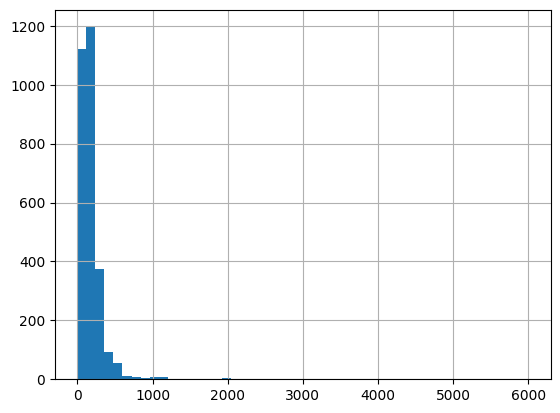

In [8]:
airbnb_boston_numeric["price_usd"].hist(bins=50)
plt.show()

In [9]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn import svm

linear_model = LinearRegression()
elastic_model = ElasticNet()
svr_model = svm.SVR()

run_regression_model(airbnb_boston_numeric, linear_model)
run_regression_model(airbnb_boston_numeric, elastic_model)
run_regression_model(airbnb_boston_numeric, svr_model)

[LinearRegression] Mean error: 255.961$ (145.58%) Model score: 0.3044901488313356
[ElasticNet] Mean error: 256.271$ (145.67%) Model score: 0.2906831912534048
[SVR] Mean error: 266.186$ (187.44%) Model score: 0.09469751371587909


## Feature Engineering - before splitting

In [10]:
airbnb_boston = pd.read_pickle("data/boston_listings_clean.pkl")
# airbnb_boston.head()

In [11]:
# Working with latitudes and longitudes - Haversine distance from Boston center in km
from datasist.feature_engineering import haversine_distance

BOSTON_CENTER = (42.355560, -71.05659)
airbnb_boston["distance_from_downtown"] = haversine_distance(airbnb_boston['latitude'], airbnb_boston['longitude'], BOSTON_CENTER[0], BOSTON_CENTER[1])
airbnb_boston.drop(columns=["latitude", "longitude"], inplace=True)

In [12]:
# Creating features from date and time
import datetime

airbnb_boston['host_for_years'] = datetime.date.today().year - airbnb_boston['host_since'].dt.year
airbnb_boston.drop(columns=["host_since"], inplace=True)

In [14]:
# Handling outliers -> pazimo da če bodo relani podatki v teh območjih potem
def find_boundaries(df, variable, distance, rule="inter-quartile"):
    if rule == "inter-quartile":
        IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
        lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
        upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
        return upper_boundary, lower_boundary
    elif rule == "meanstddev":
        lower_boundary = df[variable].mean() - (df[variable].std() * distance)
        upper_boundary = df[variable].mean() + (df[variable].std() * distance)
        return upper_boundary, lower_boundary


print(f"[BEFORE] Number of samples: {airbnb_boston.shape[0]}")
PUSD_upper_limit, PUSD_lower_limit = find_boundaries(airbnb_boston, 'price_usd', 5)
outliers_PUSD = np.where(airbnb_boston['price_usd'] > PUSD_upper_limit, True, np.where(airbnb_boston['price_usd'] < PUSD_lower_limit, True, False))
airbnb_boston = airbnb_boston.loc[~(outliers_PUSD)]
print(f"[AFTER] Number of samples: {airbnb_boston.shape[0]}")

[BEFORE] Number of samples: 3600
[AFTER] Number of samples: 3600


In [15]:
airbnb_boston.to_pickle("data/boston_listings_clean2.pkl")

In [16]:
airbnb_boston.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,price_usd,cleaning_fee_usd,tv,wifi,air_conditioning,kitchen,heating,washer,dryer,smoke_detector,essentials,hair_dryer,microwave,refrigerator,dishwasher,cooking_basics,family_kid_friendly,bathtub,private_entrance,garden_or_backyard,gym,distance_from_downtown,host_for_years
0,within a few hours,100.0,44.0,True,False,East Boston,2128,Apartment,Entire home/apt,2,1.0,1.0,0.0,Real Bed,True,False,False,super_strict_30,125.0,75.0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,2.390329,15
1,within an hour,100.0,100.0,True,True,Roxbury,2119,Guest suite,Entire home/apt,2,1.0,1.0,1.0,Real Bed,True,True,False,strict_14_with_grace_period,145.0,60.0,True,True,True,False,True,True,True,True,True,True,True,True,False,False,True,True,True,False,False,4.297944,14
2,within an hour,100.0,100.0,True,True,Roxbury,2119,Condominium,Entire home/apt,4,1.0,1.0,1.0,Real Bed,True,True,False,strict_14_with_grace_period,169.0,80.0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,4.162099,14
3,within a few hours,100.0,83.0,True,False,Downtown,2108,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,True,False,False,strict_14_with_grace_period,99.0,250.0,True,True,True,True,True,True,True,True,True,True,True,True,False,True,False,False,False,False,False,0.640989,14
4,within a few hours,100.0,83.0,True,False,Downtown,2108,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,True,False,False,strict_14_with_grace_period,150.0,250.0,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,0.535284,14


**Test Prediction**

In [17]:
airbnb_boston_numeric = airbnb_boston.select_dtypes(include='number')
airbnb_boston_numeric.dropna(axis = 0, how ='any', inplace=True)

run_regression_model(airbnb_boston_numeric, linear_model)
run_regression_model(airbnb_boston_numeric, elastic_model)
run_regression_model(airbnb_boston_numeric, svr_model)

[LinearRegression] Mean error: 83.759$ (50.99%) Model score: 0.4530070278827639
[ElasticNet] Mean error: 85.939$ (52.52%) Model score: 0.41904404846177734
[SVR] Mean error: 97.700$ (68.61%) Model score: 0.27619533351477


## Cross Validation and Grid search

In [18]:
from sklearn.model_selection import GridSearchCV

airbnb_boston = pd.read_pickle("data/boston_listings_clean2.pkl")
airbnb_boston_numeric = airbnb_boston.select_dtypes(include='number')
airbnb_boston_numeric.dropna(axis = 0, how ='any', inplace=True)


def run_grid_search_model(data, model, params_grid):
    X = data.drop(columns=["price_usd"]).values
    y = data["price_usd"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # skaliranje 
    # NEPRAVILEN NAČIN! -> vedno uporabit pipeline
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    grid_search = GridSearchCV(model, params_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

    # ocenjevanje modela
    pred = grid_search.predict(X_test_scaled)
    mse = np.sqrt(mean_squared_error(y_test,pred))
    score = grid_search.score(X_train_scaled, y_train)
    print("*** Test set score ***")
    print(f'[{type(grid_search.best_estimator_).__name__}] Mean error: {mse:.3f}$ ({mse/np.mean(pred)*100:.2f}%) Model score: {score}')

In [19]:
param_grid = [{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 10000], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
            {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

svr_model = svm.SVR()
run_grid_search_model(airbnb_boston_numeric, svr_model, param_grid)

Best parameters: {'C': 500, 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.54
*** Test set score ***
[SVR] Mean error: 80.369$ (50.50%) Model score: 0.9141133684173024


In [20]:
from sklearn.linear_model import Lasso

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_model = Lasso()
run_grid_search_model(airbnb_boston_numeric, lasso_model, param_grid)

Best parameters: {'alpha': 0.1}
Best cross-validation score: 0.44
*** Test set score ***
[Lasso] Mean error: 83.737$ (50.98%) Model score: 0.45299125041118316


## Pipelines

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

airbnb_boston = pd.read_pickle("data/boston_listings_clean2.pkl")
airbnb_boston_numeric = airbnb_boston.select_dtypes(include='number')
airbnb_boston_numeric.dropna(axis = 0, how ='any', inplace=True)

def run_regression_pipeline(data, model, param_grid):
    X = data.drop(columns=["price_usd"]).values
    y = data["price_usd"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Dodajte pipeline
    pipe = make_pipeline(StandardScaler(), model)
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train)

    # ocenjevanje modela
    print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
    print(f"Best parameters: {grid.best_params_}")
    pred = grid.predict(X_test)
    mse = np.sqrt(mean_squared_error(y_test,pred))
    score = grid.score(X_train, y_train)
    print("*** Test set score ***")
    print(f'[{type(grid.best_estimator_).__name__}] Mean error: {mse:.3f}$ ({mse/np.mean(pred)*100:.2f}%) Model score: {score}')



from sklearn.linear_model import Lasso

param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_model = Lasso()
run_regression_pipeline(airbnb_boston_numeric, lasso_model, param_grid)

Best cross-validation accuracy: 0.44
Best parameters: {'lasso__alpha': 0.1}
*** Test set score ***
[Pipeline] Mean error: 83.737$ (50.98%) Model score: 0.45299125041118316


## Adding Feature Engineering - pipelines

In [27]:
airbnb_boston = pd.read_pickle("data/boston_listings_clean2.pkl")
# print(airbnb_boston.shape)
# airbnb_boston.head()
# airbnb_boston.isnull().sum()
airbnb_boston.drop(columns=["host_response_time", "host_response_rate", "host_acceptance_rate", "cleaning_fee_usd"], inplace=True)

In [28]:
airbnb_boston.head()

,host_is_superhost,host_identity_verified,neighbourhood,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,price_usd,tv,wifi,air_conditioning,kitchen,heating,washer,dryer,smoke_detector,essentials,hair_dryer,microwave,refrigerator,dishwasher,cooking_basics,family_kid_friendly,bathtub,private_entrance,garden_or_backyard,gym,distance_from_downtown,host_for_years
0,True,False,East Boston,2128,Apartment,Entire home/apt,2,1.0,1.0,0.0,Real Bed,True,False,False,super_strict_30,125.0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,2.390329,15
1,True,True,Roxbury,2119,Guest suite,Entire home/apt,2,1.0,1.0,1.0,Real Bed,True,True,False,strict_14_with_grace_period,145.0,True,True,True,False,True,True,True,True,True,True,True,True,False,False,True,True,True,False,False,4.297944,14
2,True,True,Roxbury,2119,Condominium,Entire home/apt,4,1.0,1.0,1.0,Real Bed,True,True,False,strict_14_with_grace_period,169.0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,4.162099,14
3,True,False,Downtown,2108,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,True,False,False,strict_14_with_grace_period,99.0,True,True,True,True,True,True,True,True,True,True,True,True,False,True,False,False,False,False,False,0.640989,14
4,True,False,Downtown,2108,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,True,False,False,strict_14_with_grace_period,150.0,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,0.535284,14


In [34]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def run_regression_pipeline(data, model, param_grid):
    X = data.drop(columns=["price_usd"])
    y = data["price_usd"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    numerical_features = X_train.select_dtypes(include='number').columns.tolist()
    categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
    
    print(f"Numerical features: {numerical_features}")
    print(f"Categorical features: {categorical_features}")

    # pipeline
    numeric_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler())
    ])
    categorical_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    full_processor = ColumnTransformer(transformers=[
        ('number', numeric_pipeline, numerical_features),
        ('category', categorical_pipeline, categorical_features)
    ])
    full_pipeline = Pipeline(steps=[
        ('preprocess', full_processor),
        ('model', model)
    ])
    grid = GridSearchCV(full_pipeline, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train)

    # ocenjevanje modela
    print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
    print(f"Best parameters: {grid.best_params_}")
    pred = grid.predict(X_test)
    mse = np.sqrt(mean_squared_error(y_test,pred))
    score = grid.score(X_train, y_train)
    print("*** Test set score ***")
    print(f'[{type(grid.best_estimator_).__name__}] Mean error: {mse:.3f}$ ({mse/np.mean(pred)*100:.2f}%) Model score: {score}')



param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_model = Lasso()
run_regression_pipeline(airbnb_boston, lasso_model, param_grid)

Numerical features: ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'distance_from_downtown', 'host_for_years']
Categorical features: ['host_is_superhost', 'host_identity_verified', 'neighbourhood', 'zipcode', 'property_type', 'room_type', 'bed_type', 'requires_license', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'tv', 'wifi', 'air_conditioning', 'kitchen', 'heating', 'washer', 'dryer', 'smoke_detector', 'essentials', 'hair_dryer', 'microwave', 'refrigerator', 'dishwasher', 'cooking_basics', 'family_kid_friendly', 'bathtub', 'private_entrance', 'garden_or_backyard', 'gym']


/home/administrator/python-machine-learning-public/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.816e+05, tolerance: 2.813e+03
  model = cd_fast.enet_coordinate_descent(
/home/administrator/python-machine-learning-public/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.699e+05, tolerance: 2.748e+03
  model = cd_fast.enet_coordinate_descent(
/home/administrator/python-machine-learning-public/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase 

Best cross-validation accuracy: 0.56
Best parameters: {'model__alpha': 0.1}
*** Test set score ***
[Pipeline] Mean error: 80.755$ (49.77%) Model score: 0.5871554721689256


In [35]:
param_grid = [{'model__kernel': ['rbf'], 'model__C': [10, 100, 500,1000], 'model__gamma': [0.001, 0.01, 0.1, 1]}]

svr_model = svm.SVR()
run_regression_pipeline(airbnb_boston, svr_model, param_grid)

Numerical features: ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'distance_from_downtown', 'host_for_years']
Categorical features: ['host_is_superhost', 'host_identity_verified', 'neighbourhood', 'zipcode', 'property_type', 'room_type', 'bed_type', 'requires_license', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'tv', 'wifi', 'air_conditioning', 'kitchen', 'heating', 'washer', 'dryer', 'smoke_detector', 'essentials', 'hair_dryer', 'microwave', 'refrigerator', 'dishwasher', 'cooking_basics', 'family_kid_friendly', 'bathtub', 'private_entrance', 'garden_or_backyard', 'gym']
Best cross-validation accuracy: 0.65
Best parameters: {'model__C': 500, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
*** Test set score ***
[Pipeline] Mean error: 68.947$ (42.60%) Model score: 0.9515056438713583


## Izboljšanje ocene